# This example notebook on the usage of the lstchain_create_dl3_file Tool, does the following:
## 1. Read observed DL2 file
## 2. Use the config file to generate the event list HDUs
## 3. Add the IRFs to the event list HDUs to create the DL3 file
## 4. Index the DL3 files in the given folder

To check the simple usage of the Tool, one can do the following in a terminal - 
$ lstchain_create_dl3_file --help

or for more detailed help, 
$ lstchain_create_dl3_file --help-all

Currently the Tool requires the information of the main observed source, name and RA/Dec position in degrees, to be passed as arguments, to enter source provenance information, in the final event list HDUs.

One should use the same config file for event selection on the observed data, as used on the MC DL2 files for generating the IRFs, which are to be included in the final DL3 file.

If one wants to use energy-dependent cuts on gammaness, the IRFs should also be produced with energy-dependent cuts, and should have the GH_CUTS HDU stored with the cuts information. The DL3 Tool will use this HDU to implement the specific cuts in the respective reco energy bin. Otherwise, the Tool will look for the global gammaness cut used in the header values of the IRF HDUs, and apply the same global gammaness cut.

For sample DL2 file, one can use the file produced in the earlier session or the sample file stored at `/fefs/aswg/workspace/analysis-school-2022/src_indep/` or if the IRFs are produced using standard MC files of a particular data production, one should use the standard observed data DL2 files of the same data production

For example, if one used the point gamma MC DL2 file `/fefs/aswg/data/mc/DL2/20200629_prod5_trans_80/gamma/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/off0.4deg/dl2_gamma_20deg_180deg_off0.4deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5`,
then one should use observed data DL2 file from `/fefs/aswg/data/real/DL2/20201120/v0.7.5_test_new_calibration_tree/tailcut84_dynamic_cleaning/`

To get more explanation on the data format, check https://gamma-astro-data-formats.readthedocs.io/en/latest/index.html

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from traitlets.config.loader import Config

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import QTable
import astropy.units as u

In [2]:
from lstchain.io.io import read_data_dl2_to_QTable
from lstchain.reco.utils import get_effective_time
from lstchain.paths import run_info_from_filename, dl2_to_dl3_filename

from lstchain.high_level.hdu_table import (
    create_event_list, add_icrs_position_params,
    create_hdu_index_hdu, create_obs_index_hdu
)
from lstchain.io.event_selection import EventSelector, DL3Cuts
from lstchain.io.config import read_configuration_file

# 1. Input parameters to convert DL2 file to DL3

In [3]:
# Modify the paths as applicable.
base_dir = "/fefs/aswg/workspace/analysis-school-2022/"

dl2_dir = "src_indep/"

input_dl2_path = base_dir + dl2_dir + "dl2_LST-1.Run2968_first10.h5"

output_dl3_path = base_dir + dl2_dir

config_file = "../docs/examples/irf_tool_config.json"

irf_file = output_dl3_path + "pnt_irf_pnt_gamma_en_dep_soft_cuts.fits.gz"

source_name = "Crab"
source_ra = "83.63308333deg"
source_dec = "22.0145deg"

overwrite = True
energy_dependent_gh_cuts = True 

In [4]:
dl3_filename = dl2_to_dl3_filename(input_dl2_path)
source_pos = SkyCoord(ra=source_ra, dec=source_dec)
print("The name of the DL3 file will be,", dl3_filename)
print("Using the source RA and DEC values to get the source position,", source_pos)

The name of the DL3 file will be, dl3_LST-1.Run2968_first10.fits.gz
Using the source RA and DEC values to get the source position, <SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>


# 2. Get the information of the data DL2 file

In [5]:
data = read_data_dl2_to_QTable(input_dl2_path)

In [6]:
effective_time, elapsed_time = get_effective_time(data)
run_number = run_info_from_filename(input_dl2_path)[1]
print("The effective time of the run is,",effective_time, "and the total elapsed time of the run is,", elapsed_time)
print("The run number used from the DL2 file is,", run_number)

The effective time of the run is, 96.97985761133062 s and the total elapsed time of the run is, 101.02855944633484 s
The run number used from the DL2 file is, 2968


# 3. Apply selection cuts and bin the events as per the config file

In [7]:
config = Config(read_configuration_file(config_file))
config

{'EventSelector': {'filters': {'intensity': [100, inf],
   'width': [0, inf],
   'length': [0, inf],
   'r': [0, 1],
   'wl': [0.1, 1],
   'leakage_intensity_width_2': [0, 0.2],
   'event_type': [32, 32]}},
 'DL3Cuts': {'global_gh_cut': 0.7,
  'gh_efficiency': 0.9,
  'global_theta_cut': 0.2,
  'theta_containment': 0.68,
  'allowed_tels': [1]},
 'DataBinning': {'true_energy_min': 0.01,
  'true_energy_max': 100,
  'true_energy_n_bins_per_decade': 5,
  'reco_energy_min': 0.01,
  'reco_energy_max': 100,
  'reco_energy_n_bins_per_decade': 5,
  'energy_migration_min': 0.2,
  'energy_migration_max': 5,
  'energy_migration_n_bins': 31,
  'fov_offset_min': 0.1,
  'fov_offset_max': 1.1,
  'fov_offset_n_edges': 9,
  'bkg_fov_offset_min': 0,
  'bkg_fov_offset_max': 10,
  'bkg_fov_offset_n_edges': 21,
  'source_offset_min': 0.0001,
  'source_offset_max': 1.0001,
  'source_offset_n_edges': 1000}}

In [8]:
# Using the Components for the event selection and for applying some cuts
event_sel = EventSelector(config=Config(config))
cuts = DL3Cuts(config=Config(config))

In [9]:
# For energy dependent cuts, one can check the cuts applied for gammaness with 2D histogram
if energy_dependent_gh_cuts:
    pre_cut_log_reco_data = data["log_reco_energy"].value
    pre_cut_gammaness_data = data["gh_score"].value

In [10]:
# Applying event filters to the Hillas parameters
data_size_0 = len(data)
print("Size of the table before the filter -", len(data))
data = event_sel.filter_cut(data)
print("Size of the table after the filter -", len(data))

Size of the table before the filter - 346227
Size of the table after the filter - 186133


In [11]:
# Applying the gammaness cut
print("Size of the table before the cut -", len(data))

if energy_dependent_gh_cuts:
    gh_cuts = QTable.read(irf_file, hdu="GH_CUTS")
    data = cuts.apply_energy_dependent_gh_cuts(
        data, gh_cuts
    )
else:
    cuts.global_gh_cut = QTable.read(irf_file, hdu=1).meta["GH_CUT"]
    data = cuts.apply_global_gh_cut(data)
print("Size of the table after the cut -", len(data))

Size of the table before the cut - 186133
Size of the table after the cut - 99424


In [12]:
if energy_dependent_gh_cuts:
    post_cut_log_reco_data = data["log_reco_energy"].value
    post_cut_gammaness_data = data["gh_score"].value

Text(0.5, 1.0, 'After cuts')

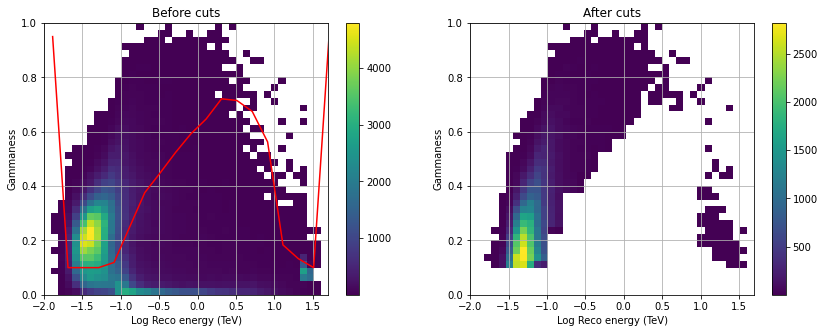

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist2d(
    pre_cut_log_reco_data, pre_cut_gammaness_data, 
    bins=(40,40), cmin=1, range=[[-2,1.7],[0,1]]
)
plt.plot(
    np.log10(gh_cuts["center"].value), gh_cuts["cut"],
    color='r'
)

plt.colorbar()
plt.grid()
plt.xlabel("Log Reco energy (TeV)")
plt.ylabel("Gammaness")
plt.title("Before cuts")

plt.subplot(122)
plt.hist2d(
    post_cut_log_reco_data, post_cut_gammaness_data, 
    bins=(40,40), cmin=1, range=[[-2,1.7],[0,1]]
)

plt.colorbar()
plt.grid()
plt.xlabel("Log Reco energy (TeV)")
plt.ylabel("Gammaness")
plt.title("After cuts")

# 4. Convert the position parameters of the events in ICRS frame and add to the table

In [14]:
data = add_icrs_position_params(data, source_pos)

# 5. Create the HDUs for the DL3 file

In [15]:
events, gti, pointing = create_event_list(
    data, run_number, source_name, source_pos, effective_time.value, elapsed_time.value
)

# 6. Add the HDUs to the final HDUList

In [16]:
hdulist = fits.HDUList([fits.PrimaryHDU(), events, gti, pointing])

In [17]:
irf_hdus = fits.open(irf_file)

In [18]:
for irf in irf_hdus[1:]:
    hdulist.append(irf)

# 7. Write the HDUList to the final DL3 file

In [19]:
hdulist.writeto(output_dl3_path + dl3_filename, overwrite=overwrite)

# 8. Check the DL3 fits info

In [20]:
f = fits.open(output_dl3_path + dl3_filename)
f.info()

Filename: /fefs/aswg/workspace/analysis-school-2022/src_indep/dl3_LST-1.Run2968_first10.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EVENTS        1 BinTableHDU     76   99424R x 11C   [K, D, D, D, D, D, K, D, D, D, D]   
  2  GTI           1 BinTableHDU     29   1R x 2C   [D, D]   
  3  POINTING      1 BinTableHDU     41   1R x 5C   [D, D, D, D, D]   
  4  EFFECTIVE AREA    1 BinTableHDU     43   1R x 5C   [19D, 19D, D, D, 19D]   
  5  ENERGY DISPERSION    1 BinTableHDU     49   1R x 7C   [19D, 19D, 30D, 30D, D, D, 570D]   
  6  BACKGROUND    1 BinTableHDU     43   1R x 5C   [19D, 19D, 20D, 20D, 380D]   
  7  GH_CUTS       1 BinTableHDU     27   19R x 4C   [D, D, D, D]   
  8  RAD_MAX       1 BinTableHDU     43   1R x 5C   [19D, 19D, D, D, 19D]   


# 9. Index the DL3 files in the folder

In [21]:
# Get the list of all DL3 files in the given output destination
list_dl3_files = sorted(Path(output_dl3_path).glob("dl3*gz"))

file_list = []
for d in list_dl3_files:
    file_list.append(d.name)
print(file_list)

['dl3_LST-1.Run2968_first10.fits.gz']


In [22]:
create_hdu_index_hdu(
    file_list, 
    Path(output_dl3_path), 
    Path(output_dl3_path)/"hdu-index.fits.gz", 
    overwrite
)

Run 2968 does not contain HDU PSF


In [23]:
create_obs_index_hdu(
    file_list, 
    Path(output_dl3_path), 
    Path(output_dl3_path)/"obs-index.fits.gz", 
    overwrite
)

# 10. Check the DL3 Index files

In [24]:
QTable.read(output_dl3_path+"hdu-index.fits.gz")

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes10,bytes1,bytes33,bytes17,int64
2968,events,events,.,dl3_LST-1.Run2968_first10.fits.gz,EVENTS,6752051
2968,gti,gti,.,dl3_LST-1.Run2968_first10.fits.gz,GTI,6752051
2968,pointing,pointing,.,dl3_LST-1.Run2968_first10.fits.gz,POINTING,6752051
2968,aeff,aeff_2d,.,dl3_LST-1.Run2968_first10.fits.gz,EFFECTIVE AREA,6752051
2968,edisp,edisp_2d,.,dl3_LST-1.Run2968_first10.fits.gz,ENERGY DISPERSION,6752051
2968,bkg,bkg_2d,.,dl3_LST-1.Run2968_first10.fits.gz,BACKGROUND,6752051
2968,rad_max,rad_max_2d,.,dl3_LST-1.Run2968_first10.fits.gz,RAD_MAX,6752051


In [25]:
QTable.read(output_dl3_path+"hdu-index.fits.gz").meta

OrderedDict([('CREATOR', 'lstchain v0.8.5.dev248+g9058afb'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLASS', 'GADF'),
             ('ORIGIN', 'CTA'),
             ('TELESCOP', 'CTA-N'),
             ('CREATED', '2022-02-02 09:34:54.880'),
             ('HDUCLAS1', 'INDEX'),
             ('HDUCLAS2', 'HDU'),
             ('INSTRUME', 'LST-1'),
             ('BASE_DIR',
              '/fefs/aswg/workspace/analysis-school-2022/src_indep'),
             ('EXTNAME', 'HDU INDEX')])

In [26]:
QTable.read(output_dl3_path+"obs-index.fits.gz")

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2968,2020-11-21,00:49:07.551,2020-11-21,00:50:48.577,83.26649185504121,21.78727828618377,26.615508929151133,63.38449107084887,98.60988543842592,83.63308333,22.0145,1605919747.55119,1605919848.577336,101.0285594463348,101.0261459350586,96.97985761133062,0.9599251750476078,Crab,WOBBLE,1,LST-1,LST-1


In [27]:
QTable.read(output_dl3_path+"obs-index.fits.gz").meta

OrderedDict([('CREATOR', 'lstchain v0.8.5.dev248+g9058afb'),
             ('HDUDOC',
              'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'),
             ('HDUVERS', '0.2'),
             ('HDUCLASS', 'GADF'),
             ('ORIGIN', 'CTA'),
             ('TELESCOP', 'CTA-N'),
             ('CREATED', '2022-02-02 09:34:54.975'),
             ('HDUCLAS1', 'INDEX'),
             ('HDUCLAS2', 'OBS'),
             ('INSTRUME', 'LST-1'),
             ('MJDREFI', 40587),
             ('MJDREFF', 0.0),
             ('EXTNAME', 'OBS INDEX')])